# Computational Statistics - Project
## Authors : Aurélie Wasem & Marcelo Tavares

In [60]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

### Dataset pre-process

In [61]:
np.random.seed(42)

# Load dataset
train_df = pd.read_csv('data/train.csv')

# Category variables
cat_vars = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'OverallQual',
    'OverallCond',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition'
]

# Encode category variables
for col in cat_vars:
    train_df[col] = train_df[col].astype('category')

# Encodage des variables catégorielles
df_encoded = pd.get_dummies(train_df, drop_first=True, dtype=int)


### Features selection

           Feature  Importance
20      GarageCars    0.336756
12       GrLivArea    0.230165
9      TotalBsmtSF    0.081278
3        YearBuilt    0.059035
6       BsmtFinSF1    0.037667
4     YearRemodAdd    0.028931
156   ExterQual_Gd    0.021865
10        2ndFlrSF    0.019373
2          LotArea    0.014178
110  OverallQual_8    0.013172
15        FullBath    0.010648
19      Fireplaces    0.009579
1      LotFrontage    0.008631
5       MasVnrArea    0.007792
22     OpenPorchSF    0.006384
8        BsmtUnfSF    0.005458
109  OverallQual_7    0.005398
191   CentralAir_Y    0.005216
0               Id    0.005071
17    BedroomAbvGr    0.004729


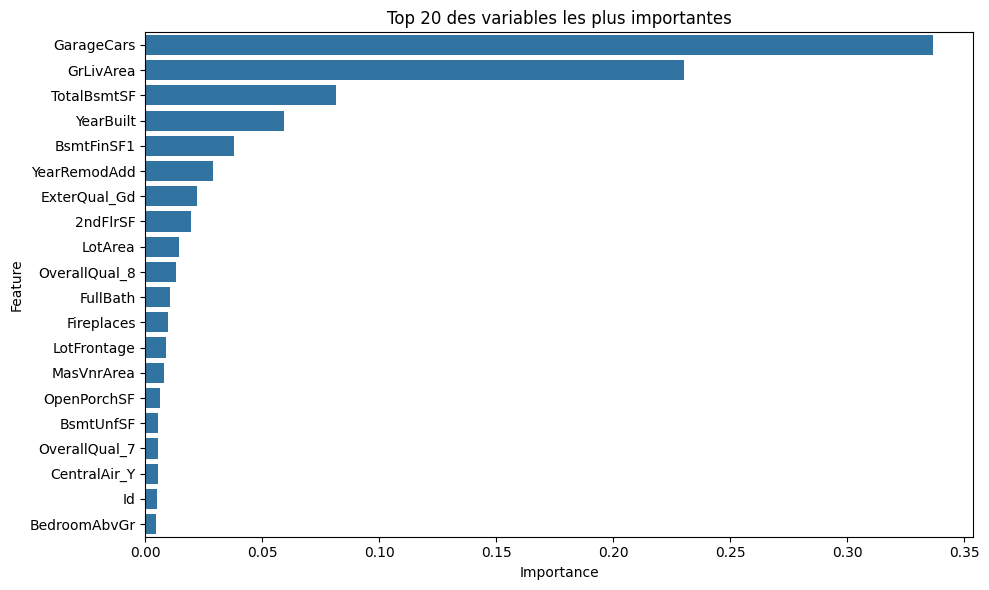

In [62]:
# Calculer la matrice de corrélation
corr_matrix = df_encoded.corr(numeric_only=True).abs()

# Sélectionner les corrélations > 0.9 (et pas la diagonale)
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Trouver les colonnes à supprimer (fortement corrélées)
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Supprimer ces colonnes du DataFrame
df_encoded = df_encoded.drop(columns=to_drop)

# Séparation des features et de la cible
X = df_encoded.drop(columns=["SalePrice"])  # ou ta variable cible
y = df_encoded["SalePrice"]

# Initialiser le modèle
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Calcul de l'importance des variables
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 des variables les plus importantes")
plt.tight_layout()
plt.show()


We select only the variables with an importance > 0.01

In [64]:
# Sélection des variables avec Importance > 0.01
top_features = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()

grades = {
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1
}

# Création du DataFrame filtré avec uniquement les top features
top_features_df = df_encoded[top_features].drop(columns=['ExterQual_Gd','OverallQual_8'])
top_features_df['ExterQual'] = train_df['ExterQual'].map(grades).astype('category')
top_features_df['OverallQual'] = train_df['OverallQual']
top_features_df['SalePrice'] = y 

top_features_df

,GarageCars,GrLivArea,TotalBsmtSF,YearBuilt,BsmtFinSF1,YearRemodAdd,2ndFlrSF,LotArea,FullBath,ExterQual,OverallQual,SalePrice
0,2,1710,856,2003,706,2003,854,8450,2,4,7,208500
1,2,1262,1262,1976,978,1976,0,9600,2,3,6,181500
2,2,1786,920,2001,486,2002,866,11250,2,4,7,223500
3,3,1717,756,1915,216,1970,756,9550,1,3,7,140000
4,3,2198,1145,2000,655,2000,1053,14260,2,4,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,1647,953,1999,0,2000,694,7917,2,3,6,175000
1456,2,2073,1542,1978,790,1988,0,13175,2,3,6,210000
1457,1,2340,1152,1941,275,2006,1152,9042,2,5,7,266500
1458,1,1078,1078,1950,49,1996,0,9717,1,3,5,142125


### Data visualisation

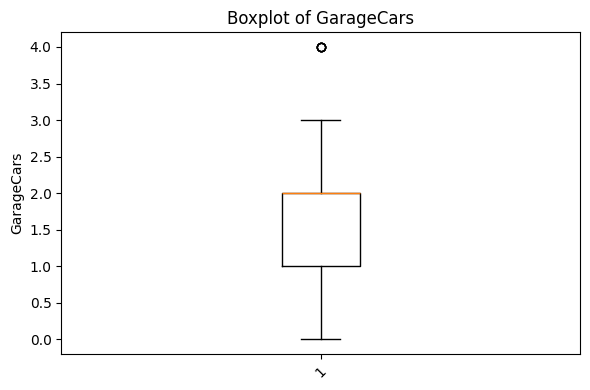

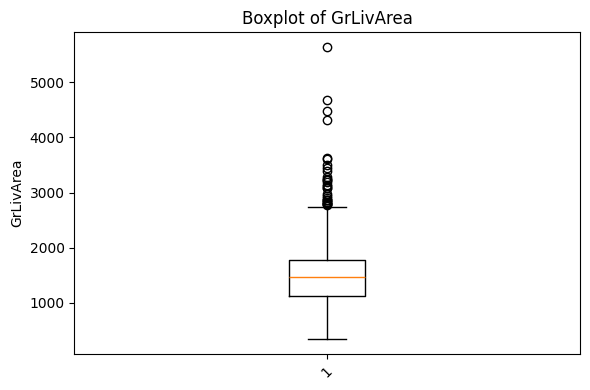

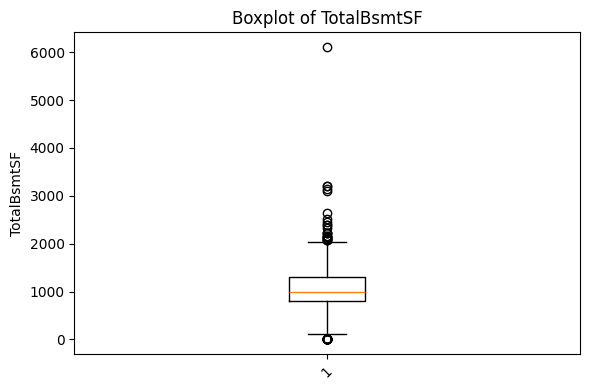

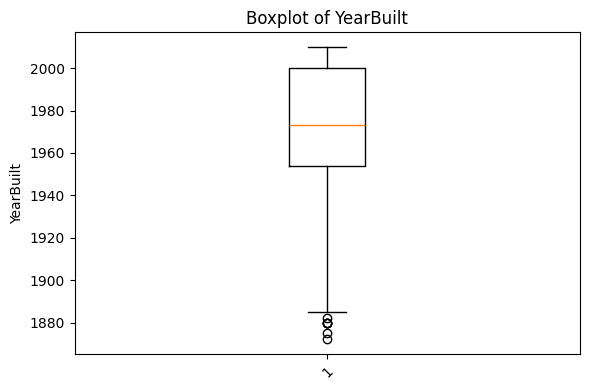

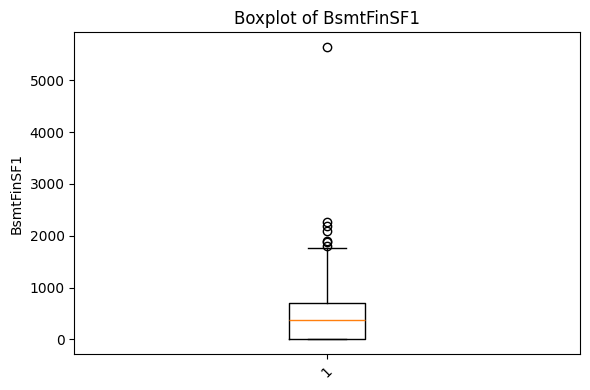

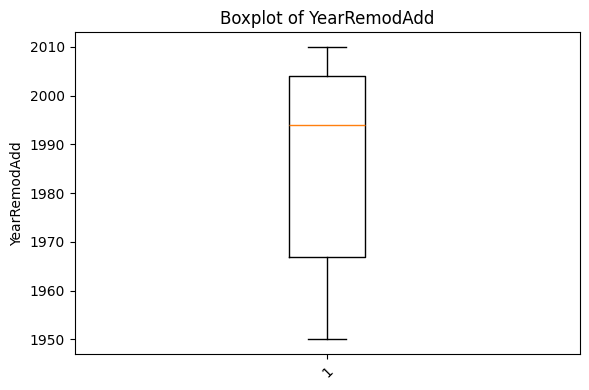

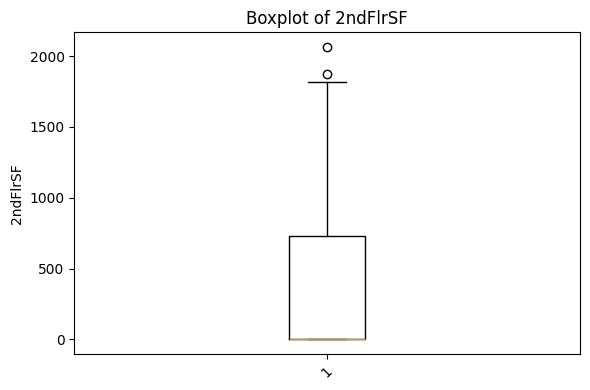

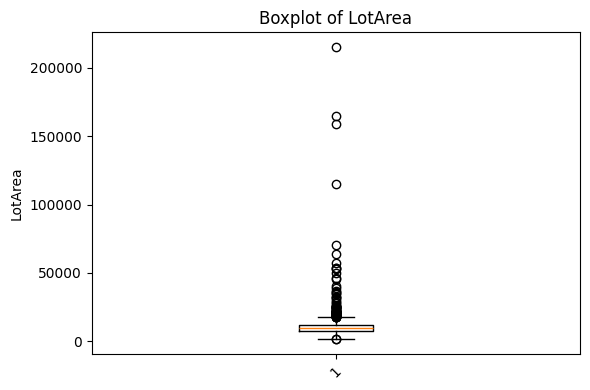

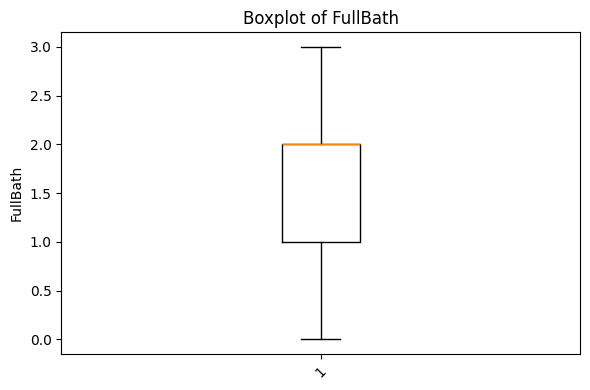

<Figure size 600x400 with 0 Axes>

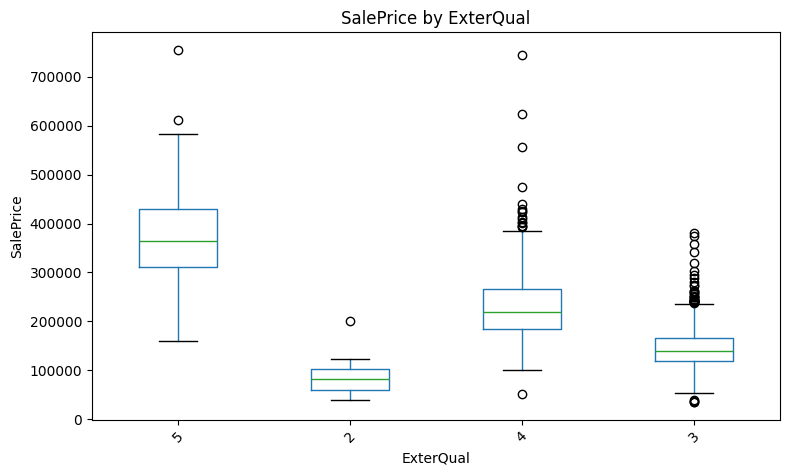

<Figure size 600x400 with 0 Axes>

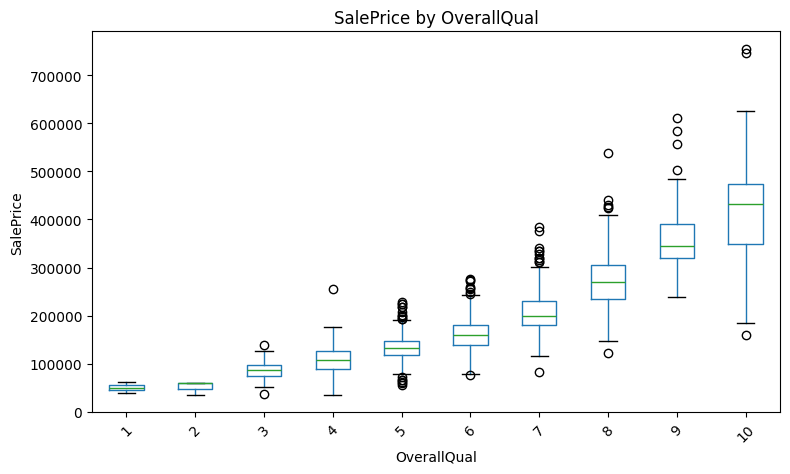

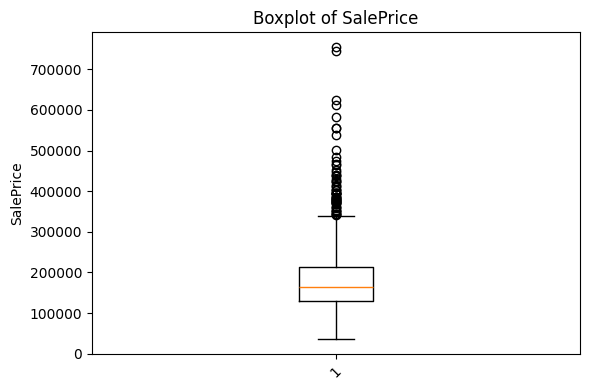

In [67]:
# Parcourir toutes les colonnes
for column in top_features_df.columns:
    plt.figure(figsize=(6, 4))
    if top_features_df[column].dtype in ['int64', 'float64']:
        # Boxplot classique pour les colonnes numériques
        plt.boxplot(top_features_df[column].dropna())
        plt.title(f'Boxplot of {column}')
        plt.ylabel(column)
    else:
        # Boxplot SalePrice par modalité pour les colonnes qualitatives
        if "SalePrice" in top_features_df.columns:
            try:
                top_features_df.boxplot(column='SalePrice', by=column, grid=False, figsize=(8, 5))
                plt.title(f'SalePrice by {column}')
                plt.suptitle('')
                plt.ylabel("SalePrice")
            except:
                plt.close()  # Certaines colonnes peuvent poser problème si trop de catégories uniques

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

### Data cleaning

In [68]:
# Fonction pour détecter les outliers via la méthode IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Stocker les seuils pour chaque variable
outlier_bounds = []
outlier_filtered_df = top_features_df.copy()

for var in top_features_df.columns:
    if not pd.api.types.is_numeric_dtype(top_features_df[var]) or pd.api.types.is_bool_dtype(top_features_df[var]):
        continue
    if var == 'SalePrice':
        continue
    series = top_features_df[var].dropna()
    lower, upper = detect_outliers_iqr(series)

    # Enregistrer les bornes
    outlier_bounds.append({
        'Variable': var,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Nb Outliers (low)': (series < lower).sum(),
        'Nb Outliers (high)': (series > upper).sum()
    })

    # Supprimer les outliers dans une copie du DataFrame
    outlier_filtered_df = outlier_filtered_df[(outlier_filtered_df[var] >= lower) & (outlier_filtered_df[var] <= upper)]

# Gestion des valeurs extrêmes pour SalePrice
series = top_features_df["SalePrice"].dropna()
lower, upper = detect_outliers_iqr(series)
outlier_bounds.append({
    'Variable': "SalePrice",
    'Lower Bound': lower,
    'Upper Bound': upper,
    'Nb Outliers (low)' : (series < lower).sum(),
    'Nb Outliers (high)': (series > upper).sum()
})

outlier_filtered_df = outlier_filtered_df[(outlier_filtered_df["SalePrice"] >= lower) & (outlier_filtered_df["SalePrice"] <= upper)]

# Résumé sous forme de tableau
outlier_bounds_df = pd.DataFrame(outlier_bounds)

# Enregistrer le DataFrame filtré sans outliers pour usage futur
filtered_df = outlier_filtered_df.copy().filter(top_features_df.columns)
filtered_df

,GarageCars,GrLivArea,TotalBsmtSF,YearBuilt,BsmtFinSF1,YearRemodAdd,2ndFlrSF,LotArea,FullBath,ExterQual,OverallQual,SalePrice
0,2,1710,856,2003,706,2003,854,8450,2,4,7,208500
1,2,1262,1262,1976,978,1976,0,9600,2,3,6,181500
2,2,1786,920,2001,486,2002,866,11250,2,4,7,223500
3,3,1717,756,1915,216,1970,756,9550,1,3,7,140000
4,3,2198,1145,2000,655,2000,1053,14260,2,4,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,1647,953,1999,0,2000,694,7917,2,3,6,175000
1456,2,2073,1542,1978,790,1988,0,13175,2,3,6,210000
1457,1,2340,1152,1941,275,2006,1152,9042,2,5,7,266500
1458,1,1078,1078,1950,49,1996,0,9717,1,3,5,142125


### Basic model

In [70]:
import statsmodels.api as sm

# Variables pour la régression linéaire
X = filtered_df.drop(columns='SalePrice')
y = filtered_df['SalePrice']

# Ajouter la constante (intercept) au modèle
X = sm.add_constant(X)

# Construire et ajuster le modèle
model = sm.OLS(y, X).fit()

# Résumé du modèle
regression_summary = model.summary()
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     742.6
Date:                Fri, 23 May 2025   Prob (F-statistic):               0.00
Time:                        16:11:11   Log-Likelihood:                -14520.
No. Observations:                1276   AIC:                         2.906e+04
Df Residuals:                    1264   BIC:                         2.913e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.128e+06   8.21e+04    -13.735      0.000   -1.29e+06   -9.67e+05
GarageCars    6340.0640   1157.664      5.477      0.000    4068.909    8611.218
GrLivArea       40.2701      4.222      9.537      0.000      31.986      48.554
TotalBsmtSF     25.4940      4.218      6.045      0.000      17.220      33.768
YearBuilt      204.1619     33.056      6.176      0.000     139.311     269.012
BsmtFinSF1      20.7657      1.659     12.517      0.000      17.511      24.020
YearRemodAdd   326.4726     39.849      8.193      0.000     248.294     404.651
2ndFlrSF         7.4163      4.225      1.755      0.079      -0.872      15.705
LotArea          2.2969      0.214     10.714      0.000       1.876       2.718
FullBath     -4945.0621   1693.866     -2.919      0.004   -8268.160   -1621.964
ExterQual     1.313e+04   1734.479      7.572      0.000    9730.282    1.65e+04
OverallQual   1.381e+04    801.453     17.228      0.000    1.22e+04    1.54e+04
==============================================================================
Omnibus:                       65.411   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.209
Skew:                          -0.189   Prob(JB):                     1.11e-42
Kurtosis:                       4.869   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given that the R^2 is not very good and the high value of the AIC, we have to process our data.

### Classical statistical inference

In [73]:
# DataFrame pour stocker les résultats
regression_results = []
stat_utilities_df = filtered_df.copy()

stat_utilities_df['ExterQual'] = stat_utilities_df['ExterQual'].astype('int')
stat_utilities_df['OverallQual'] = stat_utilities_df['OverallQual'].astype('int')
# Pour chaque variable (sauf SalePrice), on fait une régression simple
for var in stat_utilities_df.columns:
    if var == 'SalePrice':
        regression_results.append({
        'Variable': var,
        'Mean': stat_utilities_df[var].mean(),
        'Variance': stat_utilities_df[var].var()
    })
        continue
    mean = stat_utilities_df[var].mean()
    variance = stat_utilities_df[var].var()
    # Préparation des données
    X = stat_utilities_df[[var]]
    y = stat_utilities_df.loc[X.index, 'SalePrice']
    
    # Régression linéaire avec sklearn
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Prédictions et erreur standard du coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    n = len(y)
    X_mean = np.mean(X[var])
    s_squared = np.sum((residuals)**2) / (n - 2)
    se_beta = np.sqrt(s_squared / np.sum((X[var] - X_mean)**2))
    
    # Statistiques du test d'hypothèse H0: beta ≠ 0 (impact significatif)
    t_stat = coef / se_beta
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n - 2))
    
    # Intervalle de confiance à 95% du coefficient
    ci_low = coef - stats.t.ppf(0.975, df=n - 2) * se_beta
    ci_high = coef + stats.t.ppf(0.975, df=n - 2) * se_beta
    
    regression_results.append({
        'Variable': var,
        'Mean': mean,
        'Variance': variance,
        'Coefficient': coef,
        'CI 95% Lower': ci_low,
        'CI 95% Upper': ci_high,
        'T-statistic (H0: impact)': t_stat,
        'P-value': p_value,
        'Significatif ?': 'Oui' if p_value < 0.05 else 'Non'
    })

regression_df = pd.DataFrame(regression_results)

regression_df

,Variable,Mean,Variance,Coefficient,CI 95% Lower,CI 95% Upper,T-statistic (H0: impact),P-value,Significatif ?
0,GarageCars,1.705329,5.029049e-01,53565.422594,50182.804592,56948.040595,31.066510,0.0,Oui
1,GrLivArea,1440.165361,1.781130e+05,95.568514,90.165790,100.971237,34.702676,0.0,Oui
2,TotalBsmtSF,1030.582288,1.071539e+05,102.093096,94.162465,110.023726,25.255126,0.0,Oui
3,YearBuilt,1971.293887,8.856791e+02,1201.500407,1117.489840,1285.510974,28.057624,0.0,Oui
4,BsmtFinSF1,415.568966,1.562924e+05,41.150524,33.430865,48.870183,10.457747,0.0,Oui
5,YearRemodAdd,1984.753135,4.225578e+02,1576.365135,1448.197281,1704.532989,24.128959,0.0,Oui
6,2ndFlrSF,327.892633,1.667926e+05,42.080437,34.645003,49.515871,11.102858,0.0,Oui
7,LotArea,9093.717868,9.913442e+06,7.116928,6.185712,8.048145,14.993497,0.0,Oui
8,FullBath,1.522727,2.779144e-01,66028.897954,61210.222906,70847.573002,26.882354,0.0,Oui
9,ExterQual,3.365204,2.806393e-01,74253.575138,69851.220732,78655.929544,33.089732,0.0,Oui


In [98]:
# Création d'une copie du DataFrame avec des noms compatibles pour la formule
df_formula = filtered_df.copy()
print(df_formula.dtypes)
# Renommer les colonnes problématiques
df_formula = df_formula.rename(columns={
    '2ndFlrSF': 'SecondFlrSF'
})

# Mettre à jour la liste des variables avec les nouveaux noms
quant_vars_formula = [
    'SecondFlrSF' if var == '2ndFlrSF'
    else var
    for var in top_features_df.columns
    if var != 'SalePrice'
]

# Construire la formule pour la régression multiple
formula = 'SalePrice ~ ' + ' + '.join(quant_vars_formula)

# Ajuster le modèle
multi_model = smf.ols(formula=formula, data=df_formula).fit()

# Table ANOVA
anova_table = sm.stats.anova_lm(multi_model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})

# Ajouter colonne MS (Mean Square = SS / DF)
anova_table['MS'] = anova_table['SS'] / anova_table['DF']

# Ajouter colonne "Significatif ?"
anova_table['Significatif ?'] = anova_table['p_value'].apply(
    lambda p: 'NaN' if pd.isna(p) else ('Oui' if p < 0.05 else 'Non')
)
# Réorganiser les colonnes
anova_table = anova_table[['Variable', 'SS', 'DF', 'MS', 'F', 'p_value', 'Significatif ?']]

# Calcul de la somme des carrés totale (SS total) et DF total
ss_total = anova_table['SS'].sum()
df_total = anova_table['DF'].sum()

# Calcul de MS total (facultatif, ici on peut mettre NaN car ça n'a pas de signification directe)
ms_total = np.nan

# Ajout de la ligne 'Total' à la table ANOVA
anova_total_row= pd.DataFrame([{
    'Variable': 'Total',
    'SS': ss_total,
    'DF': df_total,
    'MS': ms_total,
    'F': np.nan,
    'p_value': np.nan,
    'Significatif ?': ''
}])

anova_table = pd.concat([anova_table, anova_total_row], ignore_index=True)


anova_table

GarageCars         int64
GrLivArea          int64
TotalBsmtSF        int64
YearBuilt          int64
BsmtFinSF1         int64
YearRemodAdd       int64
2ndFlrSF           int64
LotArea            int64
FullBath           int64
ExterQual       category
OverallQual     category
SalePrice          int64
dtype: object


,Variable,SS,DF,MS,F,p_value,Significatif ?
0,ExterQual,1.255837e+10,3.0,4.186124e+09,10.041850,1.534303e-06,Oui
1,OverallQual,1.758300e+11,9.0,1.953667e+10,46.865388,4.871198e-73,Oui
2,GarageCars,1.350397e+10,1.0,1.350397e+10,32.393883,1.565863e-08,Oui
3,GrLivArea,3.970387e+10,1.0,3.970387e+10,95.243314,9.768918e-22,Oui
4,TotalBsmtSF,1.197469e+10,1.0,1.197469e+10,28.725391,9.917506e-08,Oui
5,YearBuilt,2.080094e+10,1.0,2.080094e+10,49.898178,2.677686e-12,Oui
6,BsmtFinSF1,7.001944e+10,1.0,7.001944e+10,167.965591,3.846736e-36,Oui
7,YearRemodAdd,3.292431e+10,1.0,3.292431e+10,78.980230,2.133639e-18,Oui
8,SecondFlrSF,1.617641e+09,1.0,1.617641e+09,3.880465,4.907082e-02,Oui
9,LotArea,4.936255e+10,1.0,4.936255e+10,118.412968,2.045207e-26,Oui


### Factorial design  

In [ ]:
# Création des colonnes binarisées
factorial_df = stat_utilities_df.copy()

binarized_cols = []

for var in factorial_df.drop(columns='SalePrice').columns:
    median = factorial_df[var].median()
    bin_col = f"{var}_bin"
    factorial_df[bin_col] = factorial_df[var].apply(lambda x: 1 if x >= median else -1)
    binarized_cols.append(bin_col)

# Extraire uniquement les colonnes binaires créées
binarized_df = factorial_df[binarized_cols]

binarized_df

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,BsmtFinSF1_bin,YearRemodAdd_bin,2ndFlrSF_bin,LotArea_bin,FullBath_bin,ExterQual_bin,OverallQual_bin,SalePrice
0,1,1,-1,1,1,1,1,-1,1,1,1,208500
1,1,-1,1,1,1,-1,1,1,1,1,1,181500
2,1,1,-1,1,1,1,1,1,1,1,1,223500
3,1,1,-1,-1,-1,-1,1,1,-1,1,1,140000
4,1,1,1,1,1,1,1,1,1,1,1,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,-1,1,-1,1,1,-1,1,1,1,175000
1456,1,1,1,1,1,-1,1,1,1,1,1,210000
1457,-1,1,1,-1,-1,1,1,-1,1,1,1,266500
1458,-1,-1,1,-1,-1,1,1,1,-1,1,-1,142125


#### 2^(k-p)

In [146]:
# 1) Définissez vos 4 facteurs de base (A, B, C, D) – Remplacez par vos vrais noms
base_factors_fractional = ['GarageCars_bin', 'GrLivArea_bin', 'TotalBsmtSF_bin', 'YearBuilt_bin', 'BsmtFinSF1_bin']

# 2) Définissez la liste des 7 variables restantes, et pour chacune indiquez
#    avec quelle combinaison de base elle est aliasée.
#    Exemple de générateurs :
generators = {
    # variable : [liste des facteurs de base à multiplier]
    'F' : ['GarageCars_bin', 'GrLivArea_bin'],
    'G' : ['GarageCars_bin', 'TotalBsmtSF_bin'],
    'H' : ['GrLivArea_bin', 'YearBuilt_bin'],
    'I' : ['TotalBsmtSF_bin', 'BsmtFinSF1_bin'],
    'J': ['GrLivArea_bin', 'BsmtFinSF1_bin'],
    'K': ['GarageCars_bin', 'YearBuilt_bin'],
}

# 3) Générer les 16 essais en -1 / +1 pour les 4 facteurs
plan_2k_fractional = list(itertools.product([-1, 1], repeat=len(base_factors_fractional)))
plan_df_fractional = pd.DataFrame(plan_2k_fractional, columns=base_factors_fractional)

# 4) Compléter par les 7 colonnes aliasées
for var, deps in generators.items():
    plan_df_fractional[var] = plan_df_fractional[deps].prod(axis=1)

# Associer les lignes du plan à des moyennes de SalePrice
saleprice_list_fractional = []
for _, row in plan_df_fractional.iterrows():
    condition = (factorial_df[base_factors_fractional[0]] == row[base_factors_fractional[0]])
    for col in base_factors_fractional[1:]:
        condition &= (factorial_df[col] == row[col])
    matched_rows = factorial_df[condition]
    mean_price = matched_rows['SalePrice'].mean() if not matched_rows.empty else None
    saleprice_list_fractional.append(mean_price)

plan_df_fractional['MeanSalePrice'] = saleprice_list_fractional
plan_df_cleaned_factorial = plan_df_fractional.dropna(subset=['MeanSalePrice']).copy()

plan_df_cleaned_factorial

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,BsmtFinSF1_bin,F,G,H,I,J,K,MeanSalePrice
0,-1,-1,-1,-1,-1,1,1,1,1,1,1,103273.083969
1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,116805.319444
2,-1,-1,-1,1,-1,1,1,-1,1,1,-1,109438.461538
3,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,123727.272727
4,-1,-1,1,-1,-1,1,-1,1,-1,1,1,126368.275862
5,-1,-1,1,-1,1,1,-1,1,1,-1,1,139885.849057
6,-1,-1,1,1,-1,1,-1,-1,-1,1,-1,129750.000000
7,-1,-1,1,1,1,1,-1,-1,1,-1,-1,143055.555556
8,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,138311.895833
9,-1,1,-1,-1,1,-1,1,-1,-1,1,1,164250.000000


##### ANOVA

In [153]:
# Régression et ANOVA
# Mettre à jour la formule avec les bons noms de colonnes
formula = 'MeanSalePrice ~ ' + ' + '.join(plan_df_cleaned_factorial.columns[:-1])

# Recalculer le modèle et l'ANOVA
model = smf.ols(formula=formula, data=plan_df_cleaned_factorial).fit()

anova_table = sm.stats.anova_lm(model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significatif ?'] = anova_table['p_value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')

# Ligne Total
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significatif ?': ''
}])
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\aurel\AppData\Local\Temp\ipykernel_2452\3659477044.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significatif ?
0,GarageCars_bin,1.033131e+10,1.0,59.619852,2.825828e-07,1.033131e+10,Oui
1,GrLivArea_bin,9.340193e+09,1.0,53.900319,5.856215e-07,9.340193e+09,Oui
2,TotalBsmtSF_bin,3.032245e+09,1.0,17.498458,5.043764e-04,3.032245e+09,Oui
3,YearBuilt_bin,2.017028e+09,1.0,11.639854,2.925832e-03,2.017028e+09,Oui
4,BsmtFinSF1_bin,7.390820e+08,1.0,4.265089,5.282023e-02,7.390820e+08,Non
5,F,1.047486e+09,1.0,6.044825,2.371636e-02,1.047486e+09,Oui
6,G,8.234304e+07,1.0,0.475185,4.989445e-01,8.234304e+07,Non
7,H,1.349986e+05,1.0,0.000779,9.780239e-01,1.349986e+05,Non
8,I,6.143029e+04,1.0,0.000355,9.851745e-01,6.143029e+04,Non
9,J,5.024377e+06,1.0,0.028995,8.665915e-01,5.024377e+06,Non


##### Regression

In [ ]:
# Liste des variables à garder (p-value < 0.05)
significant_vars = [
    'GarageCars', 'GrLivArea', 'TotalBsmtSF',
    'YearBuilt', 'GarageCars:GrLivArea', 'GarageCars:YearBuilt'
]

# Construire la formule
formula = 'SalePrice ~ ' + ' + '.join(significant_vars)

# Créer le modèle et le résumer
model_reduced = smf.ols(formula=formula, data=filtered_df).fit()
model_summary = model_reduced.summary()
model_summary

#### 2^k

In [151]:
base_factors_full = ['GarageCars_bin', 'GrLivArea_bin', 'TotalBsmtSF_bin', 'YearBuilt_bin', 'BsmtFinSF1_bin', 'YearRemodAdd_bin', '2ndFlrSF_bin', 'LotArea_bin', 'FullBath_bin', 'ExterQual_bin', 'OverallQual_bin']

plan_2k_full = list(itertools.product([-1, 1], repeat=len(base_factors_full)))
plan_df_full = pd.DataFrame(plan_2k_full, columns=base_factors_full)

# Associer les lignes du plan à des moyennes de SalePrice
saleprice_list_full = []
for _, row in plan_df_full.iterrows():
    condition = (factorial_df[base_factors_full[0]] == row[base_factors_full[0]])
    for col in base_factors_full[1:]:
        condition &= (factorial_df[col] == row[col])
    matched_rows = factorial_df[condition]
    mean_price = matched_rows['SalePrice'].mean() if not matched_rows.empty else None
    saleprice_list_full.append(mean_price)

plan_df_full['MeanSalePrice'] = saleprice_list_full
plan_df_cleaned_full = plan_df_full.dropna(subset=['MeanSalePrice']).copy()

plan_df_cleaned_full

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,BsmtFinSF1_bin,YearRemodAdd_bin,2ndFlrSF_bin,LotArea_bin,FullBath_bin,ExterQual_bin,OverallQual_bin,MeanSalePrice
16,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,82375.000000
18,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,94692.500000
19,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,113542.315789
22,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,108166.666667
23,-1,-1,-1,-1,-1,-1,1,-1,1,1,1,119500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1,1,1,1,1,1,1,-1,-1,1,1,286000.000000
2039,1,1,1,1,1,1,1,-1,1,1,1,242632.344828
2043,1,1,1,1,1,1,1,1,-1,1,1,285182.000000
2046,1,1,1,1,1,1,1,1,1,1,-1,218000.000000


##### ANOVA

In [154]:
# Renommer la colonne problématique
plan_df_cleaned = plan_df_cleaned_full.rename(columns={"2ndFlrSF_bin": "SecondFlrSF_bin"})

# Régression et ANOVA
# Mettre à jour la formule avec les bons noms de colonnes
formula = 'MeanSalePrice ~ ' + ' + '.join(plan_df_cleaned.columns[:-1])

# Recalculer le modèle et l'ANOVA
model = smf.ols(formula=formula, data=plan_df_cleaned).fit()

anova_table = sm.stats.anova_lm(model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significatif ?'] = anova_table['p_value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')

# Ligne Total
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significatif ?': ''
}])
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\aurel\AppData\Local\Temp\ipykernel_2452\1029946824.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significatif ?
0,GarageCars_bin,1.189300e+10,1.0,23.013205,2.779250e-06,1.189300e+10,Oui
1,GrLivArea_bin,5.733265e+10,1.0,110.939864,1.108564e-21,5.733265e+10,Oui
2,TotalBsmtSF_bin,1.539667e+10,1.0,29.792879,1.164785e-07,1.539667e+10,Oui
3,YearBuilt_bin,1.144496e+10,1.0,22.146241,4.202514e-06,1.144496e+10,Oui
4,BsmtFinSF1_bin,1.064891e+10,1.0,20.605864,8.803769e-06,1.064891e+10,Oui
5,YearRemodAdd_bin,1.782934e+10,1.0,34.500133,1.364169e-08,1.782934e+10,Oui
6,SecondFlrSF_bin,3.689735e+11,1.0,713.971422,5.865635e-75,3.689735e+11,Oui
7,LotArea_bin,8.612501e+09,1.0,16.665368,6.017945e-05,8.612501e+09,Oui
8,FullBath_bin,1.551977e+07,1.0,0.030031,8.625611e-01,1.551977e+07,Non
9,ExterQual_bin,3.370031e+09,1.0,6.521080,1.125957e-02,3.370031e+09,Oui


##### Regression

In [144]:
# Liste des variables à garder (p-value < 0.05)
significant_vars = [
    'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'YearRemodAdd', 'SecondFlrSF', 'LotArea', 'ExterQual', 'OverallQual'

]

stat_utilities_df = stat_utilities_df.rename(columns={"2ndFlrSF": "SecondFlrSF"})

# Construire la formule
formula = 'SalePrice ~ ' + ' + '.join(significant_vars)

# Créer le modèle et le résumer
model_reduced = smf.ols(formula=formula, data=stat_utilities_df).fit()
model_summary = model_reduced.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     811.2
Date:                Fri, 23 May 2025   Prob (F-statistic):               0.00
Time:                        21:35:40   Log-Likelihood:                -14524.
No. Observations:                1276   AIC:                         2.907e+04
Df Residuals:                    1265   BIC:                         2.913e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.053e+06   7.82e+04    -13.459      0.000   -1.21e+06   -8.99e+05
GarageCars    6225.0958   1160.429      5.364      0.000    3948.518    8501.673
GrLivArea       37.2580      4.107      9.073      0.000      29.201      45.315
TotalBsmtSF     25.0436      4.227      5.924      0.000      16.751      33.337
YearBuilt      177.4502     31.859      5.570      0.000     114.949     239.952
BsmtFinSF1      21.3652      1.651     12.939      0.000      18.126      24.605
YearRemodAdd   313.9838     39.737      7.902      0.000     236.027     391.941
SecondFlrSF      7.3965      4.237      1.746      0.081      -0.917      15.710
LotArea          2.3440      0.214     10.932      0.000       1.923       2.765
ExterQual       1.3e+04   1739.067      7.478      0.000    9592.674    1.64e+04
OverallQual   1.377e+04    803.737     17.134      0.000    1.22e+04    1.53e+04
==============================================================================
Omnibus:                       66.815   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.450
Skew:                          -0.186   Prob(JB):                     1.09e-44
Kurtosis:                       4.916   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ANOVA from the new model

In [155]:
anova_table = sm.stats.anova_lm(model_reduced, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significatif ?'] = anova_table['p_value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')

# Ligne Total
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significatif ?': ''
}])
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\aurel\AppData\Local\Temp\ipykernel_2452\3690759916.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significatif ?
0,GarageCars,1.309914e+10,1.0,28.777615,9.645118e-08,1.309914e+10,Oui
1,GrLivArea,3.746742e+10,1.0,82.312503,4.327384e-19,3.746742e+10,Oui
2,TotalBsmtSF,1.597626e+10,1.0,35.098381,4.035277e-09,1.597626e+10,Oui
3,YearBuilt,1.412167e+10,1.0,31.024031,3.110046e-08,1.412167e+10,Oui
4,BsmtFinSF1,7.621086e+10,1.0,167.428322,4.683032e-36,7.621086e+10,Oui
5,YearRemodAdd,2.841953e+10,1.0,62.435112,5.946457e-15,2.841953e+10,Oui
6,SecondFlrSF,1.386850e+09,1.0,3.046783,8.114004e-02,1.386850e+09,Non
7,LotArea,5.440314e+10,1.0,119.518743,1.202061e-26,5.440314e+10,Oui
8,ExterQual,2.545300e+10,1.0,55.917913,1.407119e-13,2.545300e+10,Oui
9,OverallQual,1.336324e+11,1.0,293.578126,2.417015e-59,1.336324e+11,Oui


##### Modification of the new model

In [159]:
# Liste des variables à garder (p-value < 0.05)
significant_vars = [
    'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'YearRemodAdd', 'LotArea', 'ExterQual', 'OverallQual'

]

# Construire la formule
formula = 'SalePrice ~ ' + ' + '.join(significant_vars)

# Créer le modèle et le résumer
model_reduced = smf.ols(formula=formula, data=stat_utilities_df).fit()
model_summary = model_reduced.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     899.6
Date:                Fri, 23 May 2025   Prob (F-statistic):               0.00
Time:                        21:54:33   Log-Likelihood:                -14526.
No. Observations:                1276   AIC:                         2.907e+04
Df Residuals:                    1266   BIC:                         2.912e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.062e+06   7.81e+04    -13.605      0.000   -1.22e+06   -9.09e+05
GarageCars    6141.0026   1160.366      5.292      0.000    3864.552    8417.454
GrLivArea       43.6480      1.862     23.437      0.000      39.994      47.302
TotalBsmtSF     18.8768      2.323      8.126      0.000      14.320      23.434
YearBuilt      189.1792     31.167      6.070      0.000     128.034     250.324
BsmtFinSF1      21.2261      1.651     12.860      0.000      17.988      24.464
YearRemodAdd   306.7187     39.550      7.755      0.000     229.128     384.310
LotArea          2.3079      0.214     10.806      0.000       1.889       2.727
ExterQual     1.323e+04   1735.448      7.626      0.000    9830.275    1.66e+04
OverallQual   1.382e+04    803.914     17.190      0.000    1.22e+04    1.54e+04
==============================================================================
Omnibus:                       66.395   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.950
Skew:                          -0.186   Prob(JB):                     3.81e-44
Kurtosis:                       4.903   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ANOVA of this model

In [160]:
anova_table = sm.stats.anova_lm(model_reduced, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significatif ?'] = anova_table['p_value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')

# Ligne Total
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significatif ?': ''
}])
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full

C:\Users\aurel\AppData\Local\Temp\ipykernel_2452\3690759916.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significatif ?
0,GarageCars,1.276963e+10,1.0,28.008440,1.422356e-07,1.276963e+10,Oui
1,GrLivArea,2.504290e+11,1.0,549.281540,3.454739e-101,2.504290e+11,Oui
2,TotalBsmtSF,3.010813e+10,1.0,66.038044,1.042733e-15,3.010813e+10,Oui
3,YearBuilt,1.679745e+10,1.0,36.842908,1.689311e-09,1.679745e+10,Oui
4,BsmtFinSF1,7.539736e+10,1.0,165.373771,1.162918e-35,7.539736e+10,Oui
5,YearRemodAdd,2.742041e+10,1.0,60.142899,1.804131e-14,2.742041e+10,Oui
6,LotArea,5.323543e+10,1.0,116.764607,4.271780e-26,5.323543e+10,Oui
7,ExterQual,2.651617e+10,1.0,58.159569,4.725500e-14,2.651617e+10,Oui
8,OverallQual,1.347257e+11,1.0,295.502408,1.093216e-59,1.347257e+11,Oui
9,Residual,5.771959e+11,1266.0,NaN,NaN,4.559209e+08,Non


#### Simple differentiation and linear regression

In [ ]:
anova_table = sm.stats.anova_lm(model_reduced, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significatif ?'] = anova_table['p_value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')

# Ligne Total
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significatif ?': ''
}])
anova_reduce = pd.concat([anova_table, anova_total], ignore_index=True)
anova_reduce

C:\Users\aurel\AppData\Local\Temp\ipykernel_2452\725565358.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_reduce = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significatif ?
0,GarageCars_bin,7.622891e+09,1.0,47.470029,8.274346e-07,7.622891e+09,Oui
1,GrLivArea_bin,8.176518e+09,1.0,50.917625,4.894226e-07,8.176518e+09,Oui
2,TotalBsmtSF_bin,1.064622e+09,1.0,6.629721,1.766191e-02,1.064622e+09,Oui
3,YearBuilt_bin,2.108239e+09,1.0,13.128634,1.592988e-03,2.108239e+09,Oui
4,FirstFlrSF_bin,1.664103e+09,1.0,10.362867,4.116456e-03,1.664103e+09,Oui
5,F,1.052058e+09,1.0,6.551479,1.825865e-02,1.052058e+09,Oui
6,H,2.333879e+09,1.0,14.533761,1.016718e-03,2.333879e+09,Oui
7,Residual,3.372248e+09,21.0,NaN,NaN,1.605833e+08,Non
8,Total,2.739456e+10,28.0,NaN,NaN,NaN,


### SARIMA

The file contains 2 time variables, YrSold and MoSold, that we will use for the time series analysis.

In [88]:
time_df = train_df.copy()
# Créer une colonne date à partir de YrSold et MoSold
time_df['Date'] = pd.to_datetime(time_df['YrSold'].astype(str) + '-' + time_df['MoSold'].astype(str) + '-01')
time_df['Date'] = time_df['Date'].dropna()
time_df['SalePrice'] = time_df['SalePrice'].dropna()
# Grouper par mois et année, puis calculer le prix moyen de vente
ts = time_df.groupby('Date')['SalePrice'].mean().sort_index()
ts = ts.asfreq('MS')

# Afficher les premières lignes de la série temporelle
ts.head()


Date
2006-01-01    201090.000000
2006-02-01    194322.222222
2006-03-01    184982.200000
2006-04-01    174312.814815
2006-05-01    158928.289474
Freq: MS, Name: SalePrice, dtype: float64

#### Temporal Series Plot

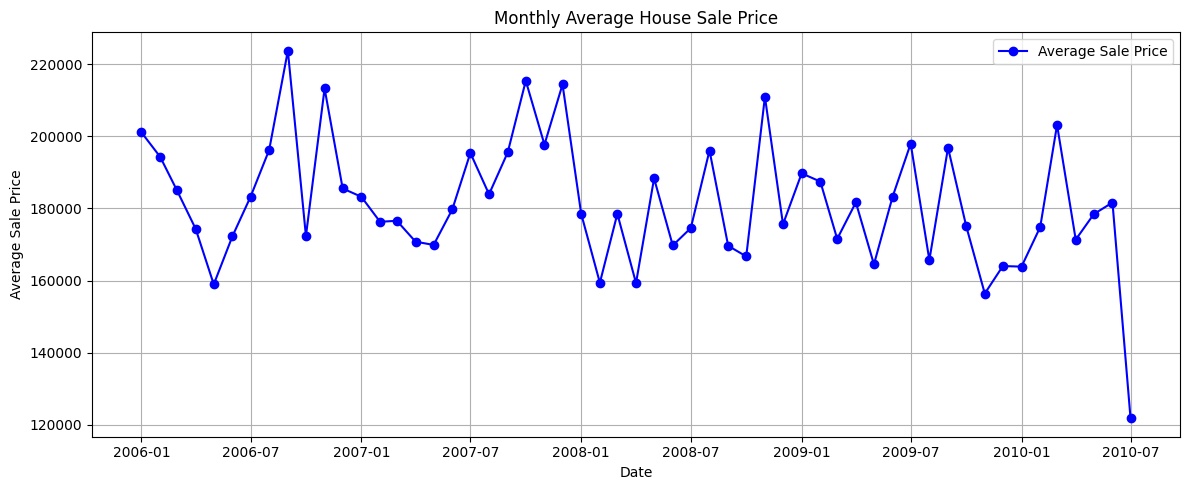

In [89]:
plt.figure(figsize=(12, 5))
plt.plot(ts, marker='o', linestyle='-', color='blue', label='Average Sale Price')
plt.title("Monthly Average House Sale Price")
plt.xlabel("Date")
plt.ylabel("Average Sale Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Here we see a moderate variability, but no strong linear trend and a possible light seasonality

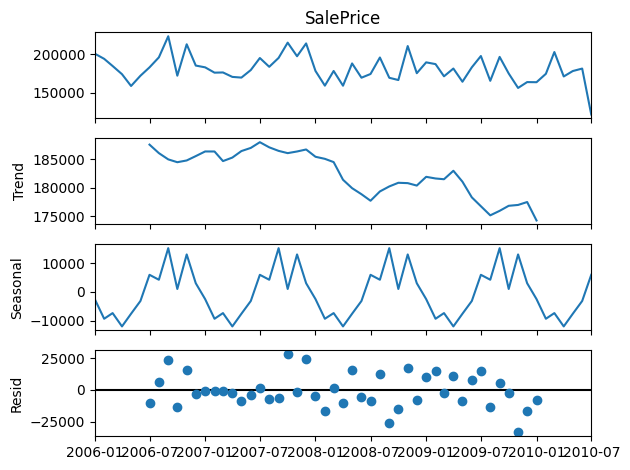

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model='additive', period=12)
result.plot()
plt.show()

We can observe a slight downward trend and clear seasonality in the time series.

#### Simple differentiation and linear regression

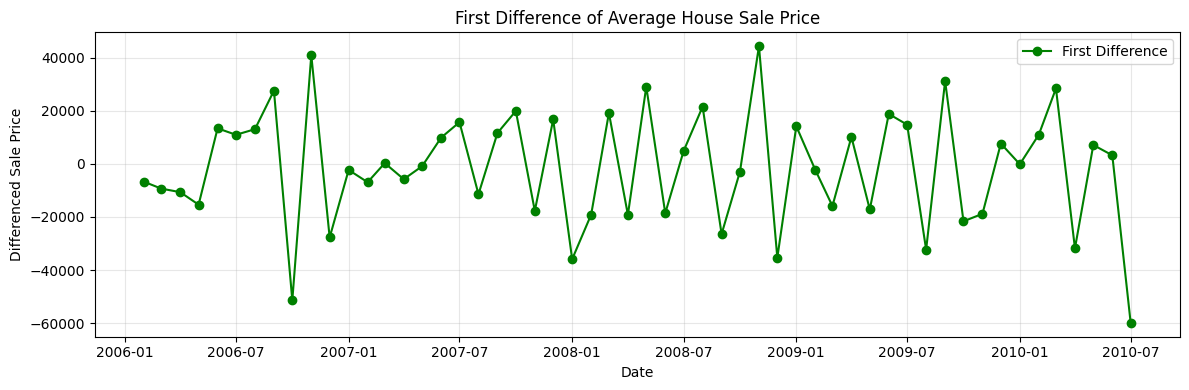

P-value original : 0.025435494179506406
P-value first difference : 0.6709843819714679


In [106]:
# Simple differentiation
ts_diff = ts.diff().dropna()

# Linear regression of the original series
X_orig = np.arange(len(ts)).reshape(-1, 1)
X_orig_const = sm.add_constant(X_orig)
model_orig = sm.OLS(ts.values, X_orig_const).fit()
pval_orig = model_orig.pvalues[1]

# Linear regression of the differentiated series
X_diff = np.arange(len(ts_diff)).reshape(-1, 1)
X_diff_const = sm.add_constant(X_diff)
model_diff = sm.OLS(ts_diff.values, X_diff_const).fit()
pval_diff = model_diff.pvalues[1]

# 4. Plot of the differentiated series
plt.figure(figsize=(12, 4))
plt.plot(ts_diff, marker='o', linestyle='-', color='green', label='First Difference')
plt.title("First Difference of Average House Sale Price")
plt.xlabel("Date")
plt.ylabel("Differenced Sale Price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("P-value original :", pval_orig)
print("P-value first difference :", pval_diff)


The original series presents a significant linear trend $(<0.05)$ and after differentiation the trend is deleted, so we can set $d=1$ for our futur ARIMA/SARIMA model.

#### Combined differentiation

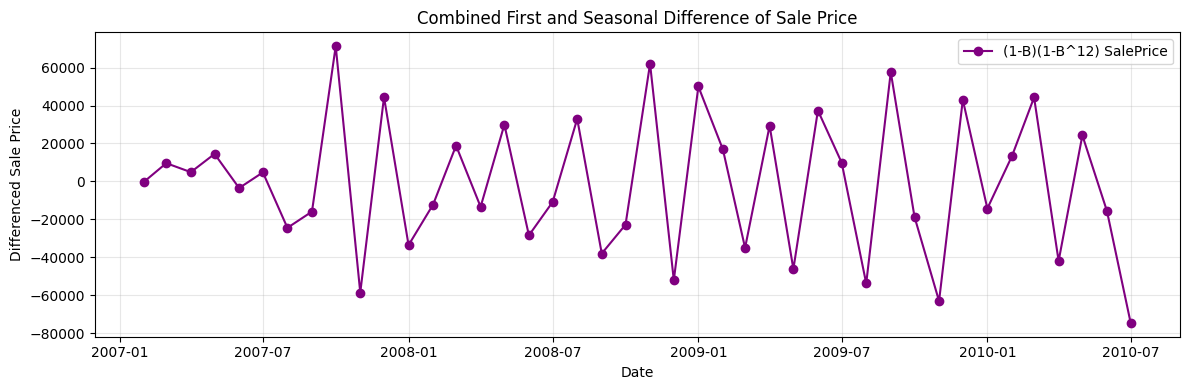

In [107]:
# Combined differentiation
combined_diff = ts.diff().dropna().diff(12).dropna()

# Combined differentiation plot
plt.figure(figsize=(12, 4))
plt.plot(combined_diff, marker='o', linestyle='-', color='purple', label='(1-B)(1-B^12) SalePrice')
plt.title("Combined First and Seasonal Difference of Sale Price")
plt.xlabel("Date")
plt.ylabel("Differenced Sale Price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


The series is centered around 0, without any evident visual structure. This suggests that the trend and seasonality have been efficiently removed. The series is now a good candidate for a AR/MA model.

#### ACF/PACF plots

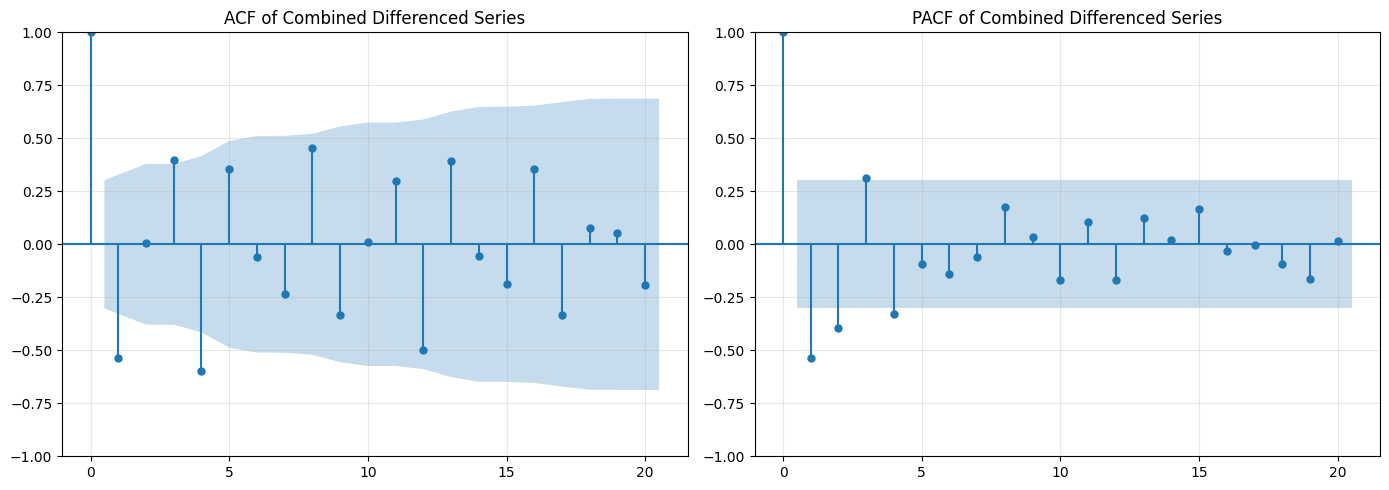

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(combined_diff, lags=20, ax=axes[0])
axes[0].set_title("ACF of Combined Differenced Series")
axes[0].grid(True, alpha=0.3)

plot_pacf(combined_diff, lags=20, ax=axes[1])
axes[1].set_title("PACF of Combined Differenced Series")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

From the ACF and PACF we can don't see any AR/MA structure. So we will start with an ARIMA model (0,1,0) and test the following ARIMA orders and check their AIC/BIC to see which one is the best model:
- ARIMA(1,1,0)
- ARIMA(0,1,1)
- ARIMA(1,1,1)

#### Comparaison des différents modèles ARIMA

In [109]:
# Orders to test
orders_to_test = [(0, 1, 0), (1, 1, 0), (0, 1, 1), (1, 1, 1)]

# Stock the results
results_arima = []

for order in orders_to_test:
    try:
        model = ARIMA(ts, order=order).fit()
        results_arima.append({
            'Order': order,
            'AIC': model.aic,
            'BIC': model.bic,
            'Log Likelihood': model.llf
        })
    except Exception as e:
        results_arima.append({
            'Order': order,
            'AIC': None,
            'BIC': None,
            'Log Likelihood': None,
            'Error': str(e)
        })

# Convertir en DataFrame pour affichage
results_df = pd.DataFrame(results_arima).sort_values(by='AIC')

results_df

,Order,AIC,BIC,Log Likelihood
2,"(0, 1, 1)",1230.819690,1234.797658,-613.409845
1,"(1, 1, 0)",1232.021891,1235.999859,-614.010946
3,"(1, 1, 1)",1232.639542,1238.606494,-613.319771
0,"(0, 1, 0)",1235.623413,1237.612397,-616.811706


From this table we see that the best order for the ARIMA model would be the $(0,1,1)$. We will now check the residuals.

##### Residuals ACF/PACF

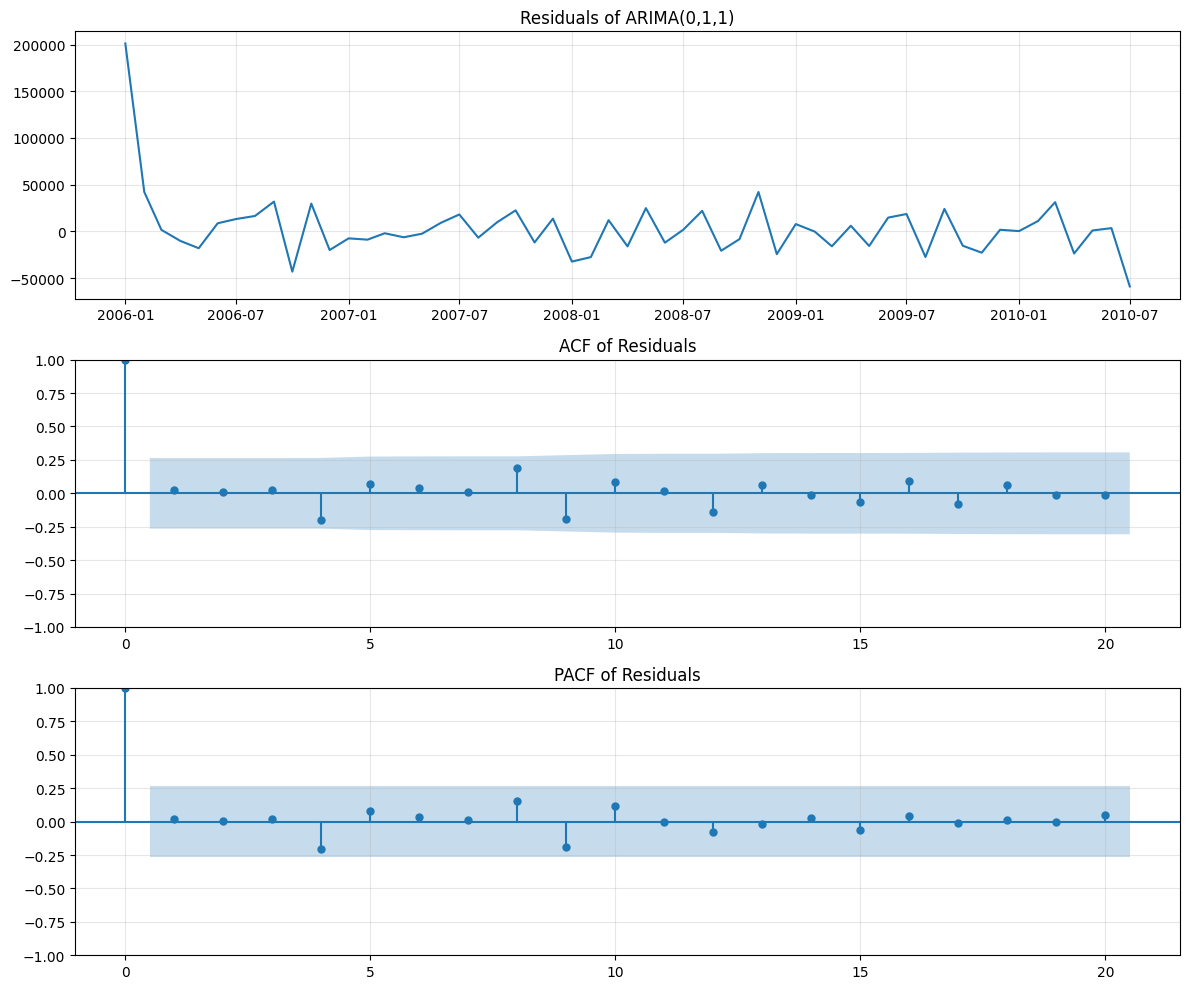

In [110]:
# Refit du modèle ARIMA(0,1,1)
best_arima = ARIMA(ts, order=(0, 1, 1)).fit()

# Récupérer les résidus
residuals = best_arima.resid.dropna()

# Tracer les résidus, leur ACF et PACF
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Résidus dans le temps
ax[0].plot(residuals)
ax[0].set_title("Residuals of ARIMA(0,1,1)")
ax[0].grid(True, alpha=0.3)

# ACF des résidus
plot_acf(residuals, lags=20, ax=ax[1])
ax[1].set_title("ACF of Residuals")
ax[1].grid(True, alpha=0.3)

# PACF des résidus
plot_pacf(residuals, lags=20, ax=ax[2])
ax[2].set_title("PACF of Residuals")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The residuals are centered around 0, without any visible trend or cyclic structure. We see a constant variation, which suggests no strong heteroskedaticity.

The autocorrelation of the residuals is globally 0. This suggests that the model captures well the series.

The PACF doesn't show any significant spike: the values are randomly distributed around 0.

#### SARIMA model estimation

In [111]:
# List of SARIMA configs to test
sarima_configs = [
    ((0, 1, 1), (0, 1, 1, 12)),  # ARIMA(0,1,1) + seasonal MA 
    ((0, 1, 1), (1, 1, 0, 12)),  # ARIMA(0,1,1) + seasonal AR
    ((0, 1, 1), (1, 1, 1, 12)),  # ARIMA(0,1,1) + seasonal AR and MA
    ((0, 1, 1), (0, 1, 0, 12)),  # ARIMA(0,1,1) + without any AR and MA seasonality
]

# Stock results
sarima_results = []

for order, seasonal in sarima_configs:
    try:
        model = SARIMAX(ts, order=order, seasonal_order=seasonal,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        sarima_results.append({
            'Order': order,
            'Seasonal': seasonal,
            'AIC': model.aic,
            'BIC': model.bic,
            'Log Likelihood': model.llf
        })
    except Exception as e:
        sarima_results.append({
            'Order': order,
            'Seasonal': seasonal,
            'AIC': None,
            'BIC': None,
            'Log Likelihood': None,
            'Error': str(e)
        })

# Afficher les résultats triés par AIC
sarima_df = pd.DataFrame(sarima_results).sort_values(by='AIC')
sarima_df

,Order,Seasonal,AIC,BIC,Log Likelihood
1,"(0, 1, 1)","(1, 1, 0, 12)",703.287592,707.491184,-348.643796
3,"(0, 1, 1)","(0, 1, 0, 12)",940.566400,943.944159,-468.283200
0,"(0, 1, 1)","(0, 1, 1, 12)",1160.787457,1164.784071,-577.393729
2,"(0, 1, 1)","(1, 1, 1, 12)",1267.780954,1273.109772,-629.890477


From here we can retain the SARIMA model $(0,1,1)\times(1,1,0,12)$ closely followed by the $(0,1,1)\times(0,1,0,12)$ model.

#### Residuals analysis

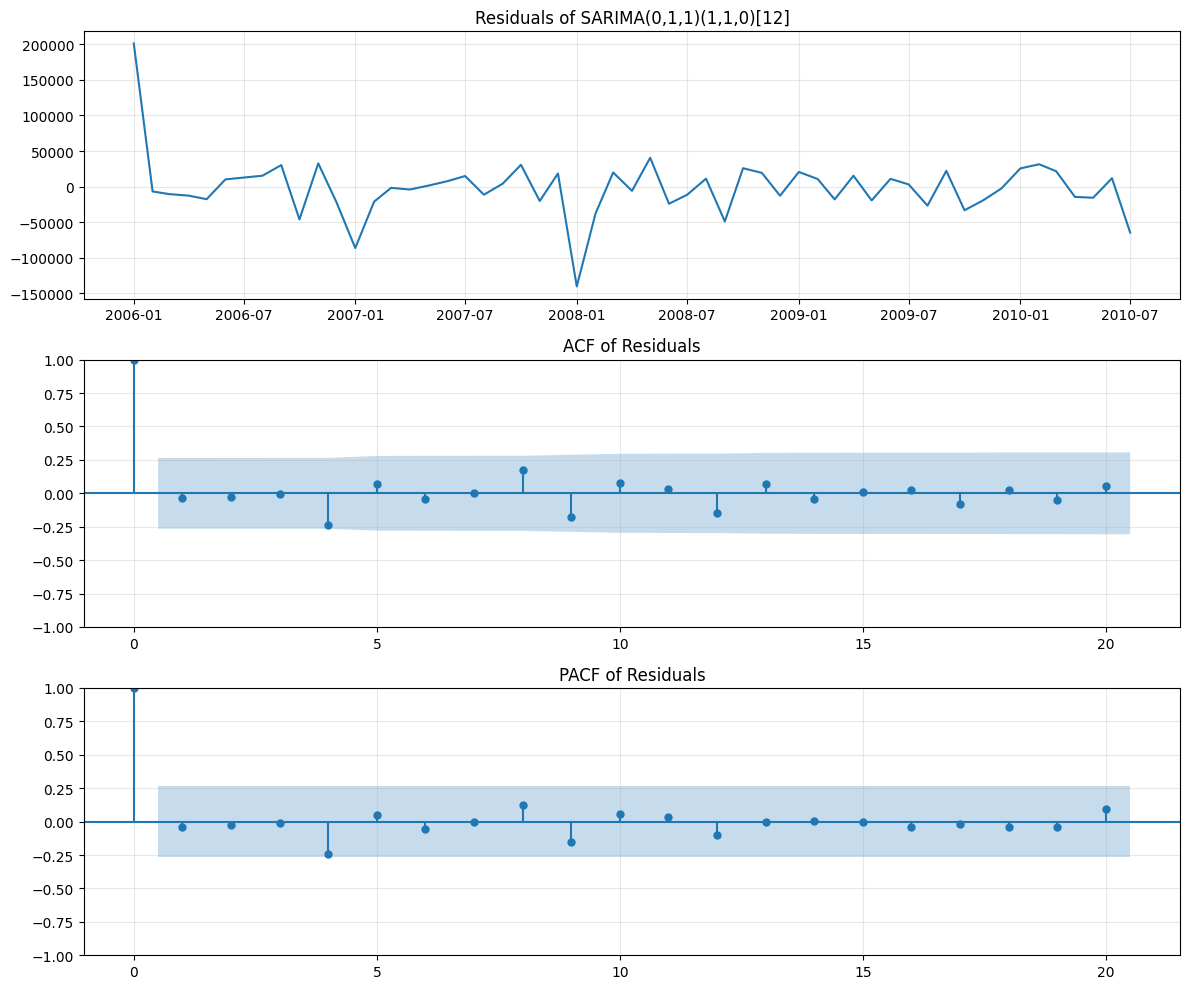

In [112]:
# Refit of the best SARIMA model
best_sarima = SARIMAX(ts, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# Model residuals
resid_sarima = best_sarima.resid.dropna()

# Plot the residuals, ACF and PACF
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Résiduals over time
ax[0].plot(resid_sarima)
ax[0].set_title("Residuals of SARIMA(0,1,1)(1,1,0)[12]")
ax[0].grid(True, alpha=0.3)

# Residuals ACF
plot_acf(resid_sarima, lags=20, ax=ax[1])
ax[1].set_title("ACF of Residuals")
ax[1].grid(True, alpha=0.3)

# Residuals PACF
plot_pacf(resid_sarima, lags=20, ax=ax[2])
ax[2].set_title("PACF of Residuals")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The residuals are globally centered around 0, without any visible trend or important variation of the variance over time.

No significant spike is visible in the autocorrelation plot. The PACF plot shows the same, that there is no presence of an residual AR structure. 

#### Summary results of the SARIMA model

In [113]:
model = SARIMAX(ts, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           SalePrice   No. Observations:                   55
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -348.644
Date:                             Fri, 23 May 2025   AIC                            703.288
Time:                                     18:21:23   BIC                            707.491
Sample:                                 01-01-2006   HQIC                           704.632
                                      - 07-01-2010                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1797      0.194     -0.927      0.354      -0.559       0.200
ar.S.L12      -0.8063      

In [29]:
sec_model = SARIMAX(ts, order=(0, 1, 0), seasonal_order=(1, 1, 0, 12),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

print(sec_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          SalePrice   No. Observations:                   55
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -347.309
Date:                            Fri, 23 May 2025   AIC                            698.617
Time:                                    15:00:25   BIC                            701.420
Sample:                                01-01-2006   HQIC                           699.514
                                     - 07-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8391      0.160     -5.241      0.000      -1.153      -0.525
sigma2      6.655e+08   3.05e-11   

Ljung-Box (Q) < 0.05 --> autocorellation
Jarque-Bera (Q) > 0.05 --> normality hypothesis is accept

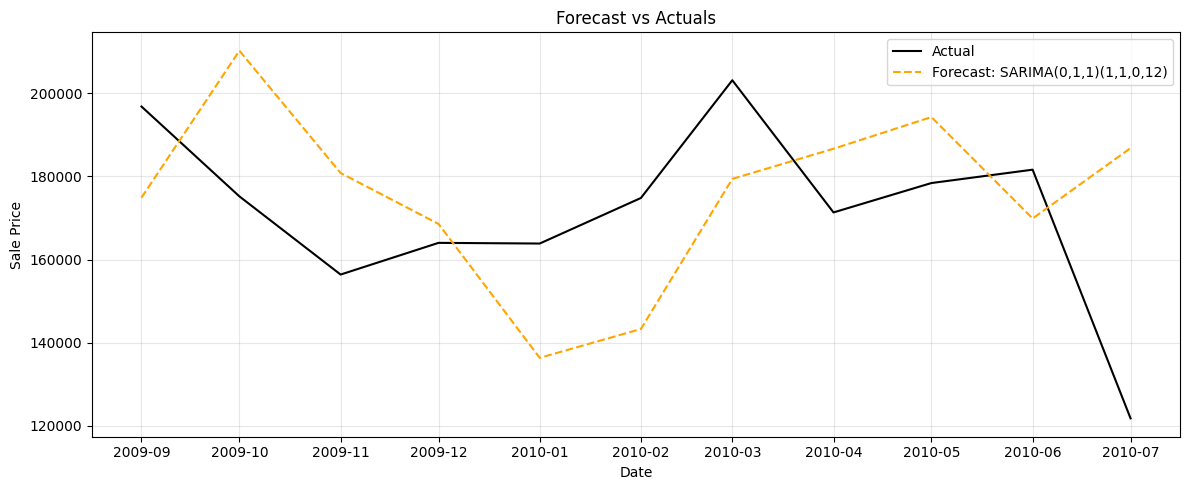

(None, 848730702.0788401)

In [114]:
# Split train/test : 80% train, 20% test
n = len(ts)
split = int(n * 0.8)
train, test = ts.iloc[:split], ts.iloc[split:]

# Meilleur modèle : SARIMA(0,1,1)(1,1,0,12)
order = (0, 1, 1)
seasonal_order = (1, 1, 0, 12)

preds = []
actuals = []
history = train.copy()

for t in range(len(test)):
    model = SARIMAX(history,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)
    
    forecast = model.forecast(steps=1).iloc[0]
    actual = test.iloc[t]

    preds.append(forecast)
    actuals.append(actual)

    history = pd.concat([history, test.iloc[[t]]])

# Erreur quadratique moyenne et tracé
forecast_error = np.array(actuals) - np.array(preds)
forecast_variance = np.var(forecast_error)

# Tracer les prédictions vs vraies valeurs
plt.figure(figsize=(12, 5))
plt.plot(test.index, actuals, label="Actual", color="black")
plt.plot(test.index, preds, label="Forecast: SARIMA(0,1,1)(1,1,0,12)", linestyle="--", color="orange")
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Sale Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show(), forecast_variance


C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

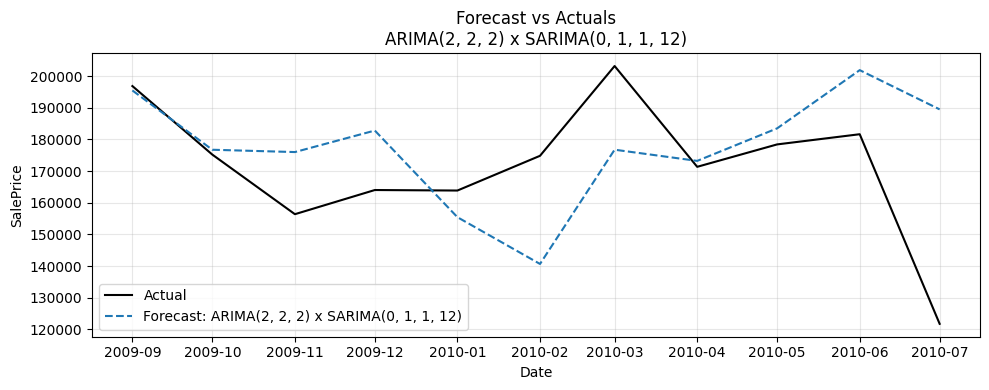

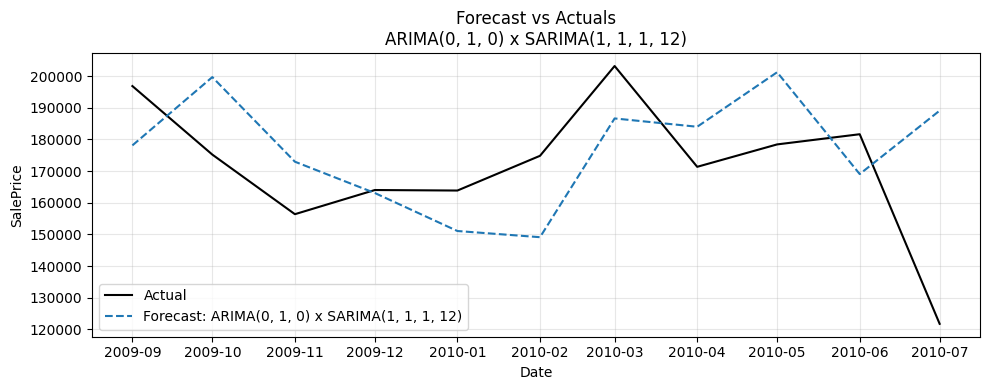

,Model,Forecast Error Variance
0,"ARIMA(2, 2, 2) x SARIMA(0, 1, 1, 12)",6.662473e+08
1,"ARIMA(0, 1, 0) x SARIMA(1, 1, 1, 12)",6.733465e+08


In [115]:
# Définir plusieurs combinaisons de modèles à tester
non_seasonal_orders = [(0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1), (2, 1, 2), (2, 2, 2), (0, 1, 0)]
seasonal_orders = [(0, 1, 0, 12), (1, 1, 0, 12), (0, 1, 1, 12), (1, 1, 1, 12), (0, 2, 2, 12)]

# Dictionnaire pour stocker les résultats
results = {}

# Boucle sur toutes les combinaisons
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        history = train.copy()

        try:
            for t in range(len(test)):
                model = SARIMAX(history,
                                order=ns_order,
                                seasonal_order=s_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)

                forecast = model.forecast(steps=1).iloc[0]
                actual = test.iloc[t]

                preds.append(forecast)
                actuals.append(actual)

                # Mettre à jour l'historique
                history = pd.concat([history, test.iloc[[t]]])

            errors = np.array(actuals) - np.array(preds)
            var_error = np.var(errors)

            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': errors,
                'Variance of Forecast Error': var_error
            }

        except Exception as e:
            results[label] = {
                'Forecasts': [],
                'Actuals': [],
                'Errors': [],
                'Variance of Forecast Error': np.inf,
                'Error': str(e)
            }

# Créer un résumé des variances d'erreur
summary_df = pd.DataFrame([
    {'Model': name, 'Forecast Error Variance': res['Variance of Forecast Error']}
    for name, res in results.items()
]).sort_values('Forecast Error Variance').reset_index(drop=True)

# Tracer les 2 meilleurs modèles
top_models = summary_df['Model'][:2]

plots = []
for name in top_models:
    res = results[name]
    plt.figure(figsize=(10, 4))
    plt.plot(test.index, res['Actuals'], label='Actual', color='black')
    plt.plot(test.index, res['Forecasts'], label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals\n{name}')
    plt.xlabel('Date')
    plt.ylabel('SalePrice')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

summary_df.head(2)
